# Coffea Processors
This is a rendered copy of [processor.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/processor.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fprocessor.ipynb)

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * An interface to the arrays being read from the TTree, either [DataFrame](https://coffeateam.github.io/coffea/api/coffea.processor.LazyDataFrame.html#coffea.processor.LazyDataFrame) or [NanoEvents](https://coffeateam.github.io/coffea/notebooks/nanoevents.html), to be used as inputs;
 * A set of [accumulator types](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html#coffea.processor.AccumulatorABC), such as `dict_accumulator` or `Hist` to be used as output; and
 * A set of parallel executors to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), and others.

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Remove `flag`, as we won't use it
 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [Candidate](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for muons
 * Calculating the dimuon invariant mass

In [1]:
import awkward as ak
from coffea import hist, processor

# register our candidate behaviors
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "mass": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("mass", "$m_{\mu\mu}$ [GeV]", 60, 60, 120),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        muons = ak.zip({
            "pt": events.Muon_pt,
            "eta": events.Muon_eta,
            "phi": events.Muon_phi,
            "mass": events.Muon_mass,
            "charge": events.Muon_charge,
        }, with_name="PtEtaPhiMCandidate")

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        
        output["sumw"][dataset] += len(events)
        output["mass"].fill(
            dataset=dataset,
            mass=dimuon.mass,
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of `uproot.lazy`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [2]:
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema

# https://github.com/scikit-hep/uproot4/issues/122
uproot.open.defaults["xrootd_handler"] = uproot.source.xrootd.MultithreadedXRootDSource

filename = "root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root"
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    entry_stop=10000,
    metadata={"dataset": "DoubleMuon"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
out

{'sumw': defaultdict_accumulator(float, {'DoubleMuon': 10000.0}),
 'mass': <Hist (dataset,mass) instance at 0x7fcc1e9f4b10>}

One could expand on this code to run over several chunks of the file, setting `entry_start` and `entry_stop` as appropriate. Then, several datasets could be processed by iterating over several files. However, [run_uproot_job](https://coffeateam.github.io/coffea/api/coffea.processor.run_uproot_job.html#coffea.processor.run_uproot_job) can help with this. One lists the datasets and corresponding files, the processor they want to run, and which executor they want to use. Available executors are listed [here](https://coffeateam.github.io/coffea/modules/coffea.processor.html#functions). Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [3]:
fileset = {
    'DoubleMuon': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root'
    ]
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": BaseSchema,
    },
    maxchunks=4,
)
out

{'sumw': defaultdict_accumulator(float,
                         {'ZZ to 4mu': 399752.0, 'DoubleMuon': 400224.0}),
 'mass': <Hist (dataset,mass) instance at 0x7fcc1ea3c190>}

Now, if we want to use more than a single core on our machine, we simply change [iterative_executor](https://coffeateam.github.io/coffea/api/coffea.processor.iterative_executor.html) for [futures_executor](https://coffeateam.github.io/coffea/api/coffea.processor.futures_executor.html), which uses the python [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) standard library. Optional arguments to these executors can be provided via `executor_args` parameter of `run_uproot_job`, such as the number of cores to use (2):

In [4]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 2},
    maxchunks=4,
)
out

{'sumw': defaultdict_accumulator(float,
                         {'ZZ to 4mu': 399752.0, 'DoubleMuon': 400224.0}),
 'mass': <Hist (dataset,mass) instance at 0x7fcc1ed73f10>}

Hopefully this ran faster than the previous cell, but that may depend on how many cores are available on the machine you are running this notebook.

## Getting fancy
Let's flesh out this analysis into a 4-muon analysis, searching for diboson events:

In [5]:
from functools import partial
import numba


@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}
    
    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 300, 0, 300)
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 300, 0, 300)
        
        self._accumulator = processor.dict_accumulator({
            'nMuons': hist.Hist(
                "Counts",
                dataset_axis,
                hist.Bin("nMuons", "Number of good muons", 6, 0, 6),
            ),
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_z1': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_z2': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_z1_mu1': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_z1_mu2': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(
                # we don't use a lambda function to avoid pickle issues
                partial(processor.defaultdict_accumulator, int)
            ),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']
        muons = ak.zip({
            "pt": events.Muon_pt,
            "eta": events.Muon_eta,
            "phi": events.Muon_phi,
            "mass": events.Muon_mass,
            "charge": events.Muon_charge,
            "softId": events.Muon_softId,
            "isolation": events.Muon_pfRelIso03_all,
        }, with_name="PtEtaPhiMCandidate")
        
        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]
        
        output['cutflow'][dataset]['all events'] += len(muons)
        
        # impose some quality and minimum pt cuts on the muons
        muons = muons[
            muons.softId
            & (muons.pt > 5)
            & (muons.isolation < 0.2)
        ]
        output['cutflow'][dataset]['at least 4 good muons'] += ak.sum(ak.num(muons) >= 4)
        output['nMuons'].fill(dataset=dataset, nMuons=ak.num(muons))
        
        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]
        
        # find all candidates with helper function
        fourmuon = find_4lep(muons, ak.ArrayBuilder()).snapshot()
        if ak.all(ak.num(fourmuon) == 0):
            # skip processing as it is an EmptyArray
            return output
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })
        
        output['cutflow'][dataset]['at least one candidate'] += ak.sum(ak.num(fourmuon) > 0)
         
        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.) & (fourmuon.z2.p4.mass > 20.)]
        output['cutflow'][dataset]['minimum dimuon mass'] += ak.sum(ak.num(fourmuon) > 0)
        
        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])
        
        output['mass'].fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        output['mass_z1'].fill(
            dataset=dataset, 
            mass=fourmuon.z1.p4.mass,
        )
        output['mass_z2'].fill(
            dataset=dataset, 
            mass=fourmuon.z2.p4.mass,
        )
        output['pt_z1_mu1'].fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        output['pt_z1_mu2'].fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
import time

tstart = time.time()    

fileset = {
    'DoubleMuon': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root'
    ]
}

output = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=FancyDimuonProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 4},
    chunksize=100000,
    maxchunks=None,
)

elapsed = time.time() - tstart
print(output)

/Users/lagray/miniconda3/envs/coffea-work/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()
/Users/lagray/miniconda3/envs/coffea-work/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()
/Users/lagray/miniconda3/envs/coffea-work/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._numba' failed to load due to 'ImportError(generic_type: type "kernel_lib" is already registered!)'.
  entrypoints.init_all()
/Users/lagray/miniconda3/envs/coffea-work/lib/python3.7/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'awkward1._connect._n


{'nMuons': <Hist (dataset,nMuons) instance at 0x7fcc1f5331d0>, 'mass': <Hist (dataset,mass) instance at 0x7fcc1f533ed0>, 'mass_z1': <Hist (dataset,mass) instance at 0x7fcc1ea22490>, 'mass_z2': <Hist (dataset,mass) instance at 0x7fcc1ed6d150>, 'pt_z1_mu1': <Hist (dataset,pt) instance at 0x7fcc1eb59c90>, 'pt_z1_mu2': <Hist (dataset,pt) instance at 0x7fcc1eb59c50>, 'cutflow': defaultdict_accumulator(..., {'ZZ to 4mu': defaultdict_accumulator(<class 'int'>, {'all events': 1499064, 'at least 4 good muons': 143618, 'at least one candidate': 143055, 'minimum dimuon mass': 81867}), 'DoubleMuon': defaultdict_accumulator(<class 'int'>, {'all events': 66128870, 'at least 4 good muons': 8289, 'at least one candidate': 3849, 'minimum dimuon mass': 485})})}


In [7]:
nevt = output['cutflow']['ZZ to 4mu']['all events'] + output['cutflow']['DoubleMuon']['all events']
print("Events/s:", nevt / elapsed)

Events/s: 29206.822973167524


What follows is just us looking at the output, you can execute it if you wish

In [8]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = output['cutflow']['ZZ to 4mu']['all events']

scaled = {}
for name, h in output.items():
    if isinstance(h, hist.Hist):
        scaled[name] = h.copy()
        scaled[name].scale({"ZZ to 4mu": lumi * zzxs / nzz}, "dataset")

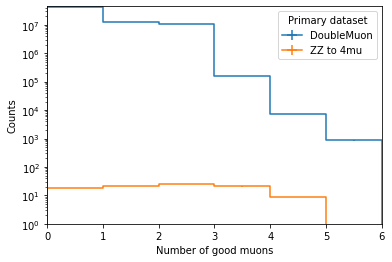

In [9]:
%matplotlib inline

ax = hist.plot1d(scaled['nMuons'], overlay='dataset')
ax.set_ylim(1, None)
ax.set_yscale('log')

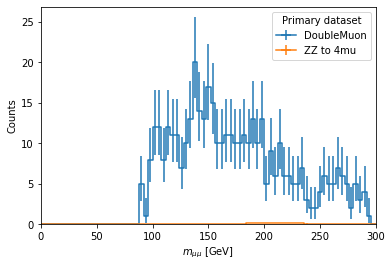

In [10]:
ax = hist.plot1d(scaled['mass'].rebin("mass", 4), overlay='dataset')

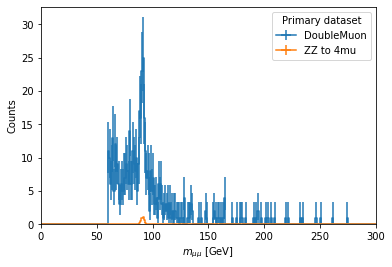

In [11]:
ax = hist.plot1d(scaled['mass_z1'], overlay='dataset')

(2.0, 300.0)

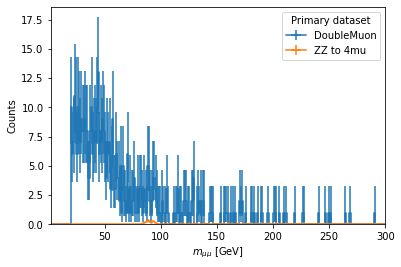

In [12]:
ax = hist.plot1d(scaled['mass_z2'], overlay='dataset')
ax.set_xlim(2, 300)
# ax.set_xscale('log')

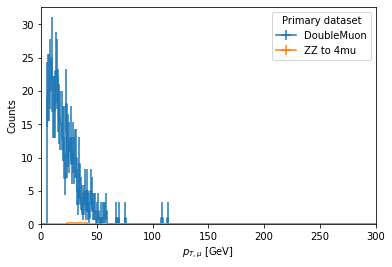

In [13]:
ax = hist.plot1d(scaled['pt_z1_mu1'], overlay='dataset')

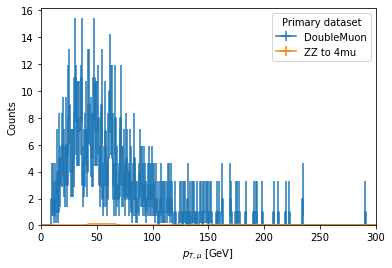

In [14]:
ax = hist.plot1d(scaled['pt_z1_mu2'], overlay='dataset')